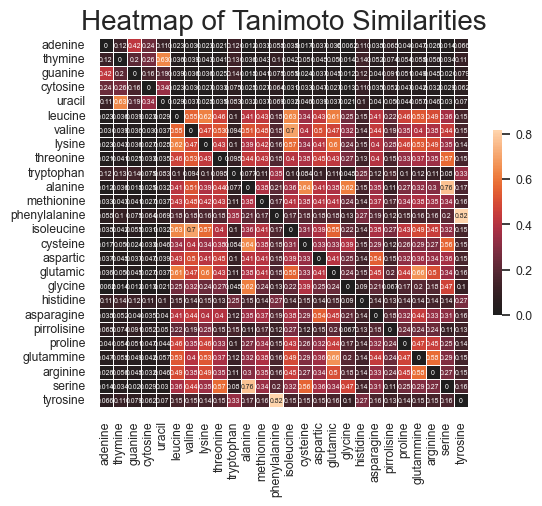

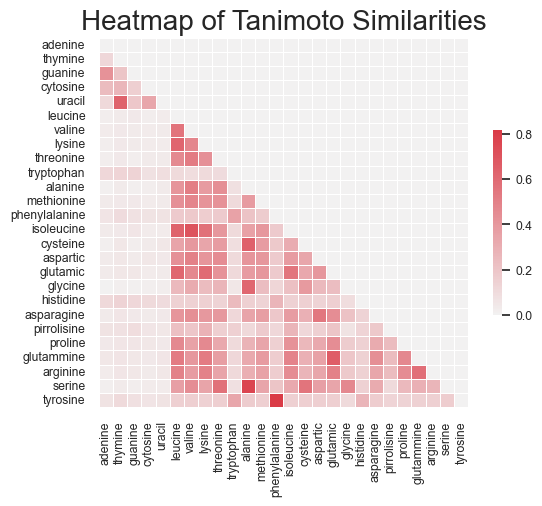

In [64]:
import time
import random
import sys
from pathlib import Path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import SimilarityMaps

# show full results
np.set_printoptions(threshold=sys.maxsize)

# Read the input CSV file.
f = open("smiles.csv","r")
ligands = f.readlines()
f.close()
ligands = ligands[1:] #remove the first line of csv file (header)

# Create arrays
molecules = []
labels = []

# Insert molecules and labels in arrays from file
for line in ligands:
    line=line.split(",")
    molecules.append(Chem.MolFromSmiles(line[2]))
    labels.append(line[1])

# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=7)
fgrps = [rdkit_gen.GetFingerprint(mol) for mol in molecules]

# Calculate number of fingerprints
nfgrps = len(fgrps)

# Define a function to calculate similarities among the molecules
def pairwise_similarity(fingerprints_list):
    global similarities
    similarities = np.zeros((nfgrps, nfgrps))
    for i in range(1, nfgrps):
            similarity = DataStructs.BulkTanimotoSimilarity(fgrps[i], fgrps[:i])
            similarities[i, :i] = similarity
            similarities[:i, i] = similarity
    return similarities

# Calculate similarities of molecules
pairwise_similarity(fgrps)
tri_lower_diag = np.tril(similarities, k=0)

# Write similarities
f = open("similarities.txt", "w")
print (similarities, file=f)
f.close()
f = open("similarities_lower_tri.txt", "w")
print (tri_lower_diag, file=f)
f.close()

# Visualize the similarities
normal_heatmap(similarities)
lower_tri_heatmap(similarities)


def normal_heatmap (sim):
    global labels
    sns.set(font_scale=0.8)
    # Generate the plot
    plot = sns.heatmap(sim, annot = True, annot_kws={"fontsize":5}, center=0,
            square=True, xticklabels=labels, yticklabels=labels, linewidths=.7, cbar_kws={"shrink": .5})
    plt.title('Heatmap of Tanimoto Similarities', fontsize = 20) # title with fontsize 20
    plt.show()
    # Save the plot
    fig = plot.get_figure()
    fig.savefig("tanimoto_heatmap.png") 


def lower_tri_heatmap (sim):
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    lower_tri_plot = sns.heatmap(tri_lower_diag, annot = False, cmap=cmap,center=0,
            square=True, xticklabels=labels, yticklabels=labels, linewidths=.7, cbar_kws={"shrink": .5})
    plt.title('Heatmap of Tanimoto Similarities', fontsize = 20)
    plt.show()
    fig = lower_tri_plot.get_figure()
    fig.savefig("tanimoto_heatmap_lw_tri.png") 


